<a href="https://colab.research.google.com/github/AeroEng16/TennisPrediction/blob/main/24LiveScraping_APIOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
%pip install requests
%pip install pandas
import requests
import re
from datetime import datetime, timedelta
import pandas as pd
import json


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Glicko Rating Setup

In [33]:
"""
Copyright (c) 2009 Ryan Kirkman

Permission is hereby granted, free of charge, to any person
obtaining a copy of this software and associated documentation
files (the "Software"), to deal in the Software without
restriction, including without limitation the rights to use,
copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following
conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
OTHER DEALINGS IN THE SOFTWARE.
"""

import math

class Player:
    # Class attribute
    # The system constant, which constrains
    # the change in volatility over time.
    _tau = 0.5

    def getRating(self):
        return (self.__rating * 173.7178) + 1500

    def setRating(self, rating):
        self.__rating = (rating - 1500) / 173.7178

    rating = property(getRating, setRating)

    def getRd(self):
        return self.__rd * 173.7178

    def setRd(self, rd):
        self.__rd = rd / 173.7178

    rd = property(getRd, setRd)

    def __init__(self, rating = 1500, rd = 350, vol = 0.06):
        # For testing purposes, preload the values
        # assigned to an unrated player.
        self.setRating(rating)
        self.setRd(rd)
        self.vol = vol

    def _preRatingRD(self):
        """ Calculates and updates the player's rating deviation for the
        beginning of a rating period.

        preRatingRD() -> None

        """
        self.__rd = math.sqrt(math.pow(self.__rd, 2) + math.pow(self.vol, 2))

    def update_player(self, rating_list, RD_list, outcome_list):
        """ Calculates the new rating and rating deviation of the player.

        update_player(list[int], list[int], list[bool]) -> None

        """
        # Convert the rating and rating deviation values for internal use.
        rating_list = [(x - 1500) / 173.7178 for x in rating_list]
        RD_list = [x / 173.7178 for x in RD_list]

        v = self._v(rating_list, RD_list)
        self.vol = self._newVol(rating_list, RD_list, outcome_list, v)
        self._preRatingRD()

        self.__rd = 1 / math.sqrt((1 / math.pow(self.__rd, 2)) + (1 / v))

        tempSum = 0
        for i in range(len(rating_list)):
            tempSum += self._g(RD_list[i]) * \
                       (outcome_list[i] - self._E(rating_list[i], RD_list[i]))
        self.__rating += math.pow(self.__rd, 2) * tempSum


    def _newVol(self, rating_list, RD_list, outcome_list, v):
        """ Calculating the new volatility as per the Glicko2 system.

        _newVol(list, list, list) -> float

        """
        i = 0
        delta = self._delta(rating_list, RD_list, outcome_list, v)
        a = math.log(math.pow(self.vol, 2))
        tau = self._tau
        x0 = a
        x1 = 0

        while x0 != x1:
            # New iteration, so x(i) becomes x(i-1)
            x0 = x1
            d = math.pow(self.__rating, 2) + v + math.exp(x0)
            h1 = -(x0 - a) / math.pow(tau, 2) - 0.5 * math.exp(x0) \
            / d + 0.5 * math.exp(x0) * math.pow(delta / d, 2)
            h2 = -1 / math.pow(tau, 2) - 0.5 * math.exp(x0) * \
            (math.pow(self.__rating, 2) + v) \
            / math.pow(d, 2) + 0.5 * math.pow(delta, 2) * math.exp(x0) \
            * (math.pow(self.__rating, 2) + v - math.exp(x0)) / math.pow(d, 3)
            x1 = x0 - (h1 / h2)

        return math.exp(x1 / 2)

    def _delta(self, rating_list, RD_list, outcome_list, v):
        """ The delta function of the Glicko2 system.

        _delta(list, list, list) -> float

        """
        tempSum = 0
        for i in range(len(rating_list)):
            tempSum += self._g(RD_list[i]) * (outcome_list[i] - self._E(rating_list[i], RD_list[i]))
        return v * tempSum

    def _v(self, rating_list, RD_list):
        """ The v function of the Glicko2 system.

        _v(list[int], list[int]) -> float

        """
        tempSum = 0
        for i in range(len(rating_list)):
            tempE = self._E(rating_list[i], RD_list[i])
            tempSum += math.pow(self._g(RD_list[i]), 2) * tempE * (1 - tempE)
        return 1 / tempSum

    def _E(self, p2rating, p2RD):
        """ The Glicko E function.

        _E(int) -> float

        """
        return 1 / (1 + math.exp(-1 * self._g(p2RD) * \
                                 (self.__rating - p2rating)))

    def _g(self, RD):
        """ The Glicko2 g(RD) function.

        _g() -> float

        """
        return 1 / math.sqrt(1 + 3 * math.pow(RD, 2) / math.pow(math.pi, 2))

    def did_not_compete(self):
        """ Applies Step 6 of the algorithm. Use this for
        players who did not compete in the rating period.

        did_not_compete() -> None

        """
        self._preRatingRD()



# Scraping Data

In [34]:
## Load existing match data

matchURL = "https://raw.githubusercontent.com/AeroEng16/TennisPrediction/main/scrapedMatchData.csv"
df_matches = pd.read_csv(matchURL)


previousFinalDate = pd.to_datetime(df_matches['Date']).max().date()


In [35]:

#Base URLS

listOfTournamentsURL = "https://www.24live.com/api/match-list-category/10?lang=en&type=all&sort=alpha&from=CURRENTDATE%2000:00:00&to=CURRENTDATE%2023:59:59"
listOfMatchesURL = "https://www.24live.com/api/match-list-data/10?lang=en&type=all&subtournamentIds=COMMASEPARATEDTOURNAMENTIDS&sort=alpha&short=1&from=CURRENTDATE%2000:00:00&to=CURRENTDATE%2023:59:59"

baseMatchURL = "https://www.24live.com/api/match/MATCHID"
todayDate = datetime.now().strftime("%x").replace("/","_")

allMatchdf = pd.DataFrame(columns=['Date','Tournament',"Court Type",'Player1', 'Player1_Rank', 'Player1_RankingPoints', 'Player2', 'Player2_Rank', 'Player2_RankingPoints','Best of Sets','ScoreProgression_Games','ScoreProgression_Sets',
                                   'Player1_Aces','Player1_BreakpointsWon','Player1_DoubleFaults','Player1_FirstServePointsWon','Player1_FirstServeSuccessful','Player1_MaxPointsInARow','Player1_PointsWon','Player1_SecondServePointsWon','Player1_SecondServeSuccessful','Player1_ServiceGamesWon','Player1_ServicePointsLost','Player1_ServicePointsWon','Player1_TiebreaksWon','Player1_TotalBreakpoints','Player1_GamesWon','Player1_MaxGamesInARow',
                                   'Player2_Aces','Player2_BreakpointsWon','Player2_DoubleFaults','Player2_FirstServePointsWon','Player2_FirstServeSuccessful','Player2_MaxPointsInARow','Player2_PointsWon','Player2_SecondServePointsWon','Player2_SecondServeSuccessful','Player2_ServiceGamesWon','Player2_ServicePointsLost','Player2_ServicePointsWon','Player2_TiebreaksWon','Player2_TotalBreakpoints','Player2_GamesWon','Player2_MaxGamesInARow'])

# Loop through each day in the calendar from current date back to June 2022 when details are not available earlier than that (as of 21/02/24)
for dayNumber in range(1,1200):
    d = datetime.today() - timedelta(days=dayNumber)
    if d.date() == previousFinalDate:
      break
    d = d.strftime('%Y-%m-%d').replace("/","-")

    currentTournamentList = listOfTournamentsURL.replace('CURRENTDATE',d)

    tournamentList = requests.get(currentTournamentList)
    tournamentList = [i for i in tournamentList.json() if i["category_name"]=="ATP" and i["singles_doubles"]==1]

    tournamentList = [{key: value for key, value in zip(i.keys(), i.values()) if "sub_tournament_id" in key or "tournament_name" in key or "sub_tournament_ground" in key} for i in tournamentList]

    tournIDList = [str(i["sub_tournament_id"])+"," for i in tournamentList]
    tournIDList = "".join(tournIDList)[:-1]

    currentMatchListURL = listOfMatchesURL.replace("CURRENTDATE",d)
    currentMatchListURL = currentMatchListURL.replace("COMMASEPARATEDTOURNAMENTIDS",tournIDList)

    currentDayMatchList = requests.get(currentMatchListURL).json()
    allMatchIds = [i["id"] for i in currentDayMatchList]

    #allMatches = []
    #allMatchIds = []

# Loop through match ids
    for id in allMatchIds:
        matchURL = baseMatchURL.replace("MATCHID",str(id))
        matchResponse = requests.get(matchURL)
        try:
            jsonResponse = matchResponse.json()
        except requests.exceptions.JSONDecodeError:
            print("jsonError")
            continue
        # Extract player name, rank and rank points
        if jsonResponse["code_state"]!="ended":
            print("no match data for "+str(id))
            continue

        player1={}
        player2={}
        player1["name"]  = re.split("\(",[player for player in jsonResponse["participants"] if player["type"]=="home_team"][0]["name"])[0].strip()
        player2["name"] = re.split("\(",[player for player in jsonResponse["participants"] if player["type"]=="away_team"][0]["name"])[0].strip()
        if "/" in player1["name"]:
            continue
        # if either player isn't ranked then ignore match and continue
        try:
            player1["rankingPoints"] = [points for points in jsonResponse["tennis_rankings"] if points["info"]["name"]==player1["name"]][0]["points"]
        except IndexError:
            continue
        try:
            player2["rankingPoints"] = [points for points in jsonResponse["tennis_rankings"] if points["info"]["name"]==player2["name"]][0]["points"]
        except IndexError:
            continue
        player1["ranking"] = [points for points in jsonResponse["tennis_rankings"] if points["info"]["name"]==player1["name"]][0]["ranking"]
        player2["ranking"] = [points for points in jsonResponse["tennis_rankings"] if points["info"]["name"]==player2["name"]][0]["ranking"]
        # Extract Player stats from the game
        try:
          player1Stats = jsonResponse["participantStatistics"]["home"]
          player2Stats = jsonResponse["participantStatistics"]["away"]
        except:
          continue

        # Extract game timeline from
        matchData = jsonResponse["live_timelines"]
        matchData = [[item["home_score"],item["away_score"]] for item in matchData if item["type"] =="period_score" or item["type"]=="period_start"]
        matchData = [score for score in matchData if score != [None,None]]
        matchDataBySet = []
        for i,score in enumerate(matchData):

            if i==0:
                matchDataBySet.append([score])
            else:
                if sum(matchData[i])>sum(matchData[i-1]):
                    matchDataBySet[-1].append(score)
                elif sum(matchData[i])==sum(matchData[i-1]):
                    continue
                else:
                    matchDataBySet.append([score])

        numberOfSets = len(matchDataBySet)
        setScores = []
        for i in range(0,numberOfSets):
            setScores.append([0,0])

        for i,score in enumerate(matchDataBySet):

            try:
                if score[-1][0]>score[-1][1]:
                #setScores[i][0]+=1
                    setScores = [[x[0]+1,x[1]] if count>=i else x for count,x in enumerate(setScores) ]
            except IndexError:
                print("Error for match data "+str(id))
                continue
            if score[-1][1]>score[-1][0]:
                setScores = [[x[0],x[1]+1] if count>=i else x for count,x in enumerate(setScores) ]
        try:
            bestOf = 3 if max(setScores[-1])==2  else 5
        except IndexError:
            print("Error for match data "+str(id))
            continue
        allMatchdf.loc[0 if pd.isnull(allMatchdf.index.max()) else allMatchdf.index.max() + 1]=[d,jsonResponse["sub_tournament_name"],jsonResponse["sub_tournament_ground"].replace("web.ground-type_",""),player1["name"],player1["ranking"],player1["rankingPoints"],player2["name"],player2["ranking"],player2["rankingPoints"],bestOf,matchDataBySet,setScores,
                                                                                                player1Stats["Aces"],player1Stats['BreakpointsWon'],player1Stats['DoubleFaults'],player1Stats['FirstServePointsWon'],player1Stats['FirstServeSuccessful'],player1Stats['MaxPointsInARow'],player1Stats["PointsWon"],player1Stats['SecondServePointsWon'],player1Stats['SecondServeSuccessful'],player1Stats['ServiceGamesWon'],player1Stats['ServicePointsLost'],player1Stats['ServicePointsWon'],player1Stats['TiebreaksWon'],player1Stats['TotalBreakpoints'],player1Stats['GamesWon'],player1Stats['MaxGamesInARow'],
                                                                                                player2Stats["Aces"],player2Stats['BreakpointsWon'],player2Stats['DoubleFaults'],player2Stats['FirstServePointsWon'],player2Stats['FirstServeSuccessful'],player2Stats['MaxPointsInARow'],player2Stats["PointsWon"],player2Stats['SecondServePointsWon'],player2Stats['SecondServeSuccessful'],player2Stats['ServiceGamesWon'],player2Stats['ServicePointsLost'],player2Stats['ServicePointsWon'],player2Stats['TiebreaksWon'],player2Stats['TotalBreakpoints'],player2Stats['GamesWon'],player2Stats['MaxGamesInARow']]
        if len(allMatchdf.index) % 100 == 0:
            allMatchdf.to_csv("matchData_test_"+todayDate+".json", sep=',', index=False, encoding='utf-8')



no match data for 3991593
no match data for 3989273
no match data for 3984957
no match data for 3960721
no match data for 3960629
no match data for 3960635
no match data for 3983023
no match data for 3965569
no match data for 3960697
no match data for 3965565
no match data for 3965577


# Add additional data to scraped data

In [36]:
# Python program to get average of a list
def Average(lst):
    return sum(lst) / len(lst)
###############################################################################################################################
## Convert string of lists to lists, create matchID, create winner column and calculate average games per set across dataset ##
###############################################################################################################################
import ast
df_matches["ScoreProgression_Games"] = df_matches["ScoreProgression_Games"].apply(ast.literal_eval)
df_matches["ScoreProgression_Sets"] = df_matches["ScoreProgression_Sets"].apply(ast.literal_eval)
df_matches["matchID"] = "Player1Rank_"+df_matches["Player1_Rank"].astype(str)+"_Player2Rank_"+df_matches["Player2_Rank"].astype(str)+"_Date_"+df_matches["Date"]
df_matches["Winner"] = df_matches.apply(lambda x: "Player1" if x["ScoreProgression_Sets"][-1][0]>x["ScoreProgression_Sets"][-1][1] else "Player2",axis=1)
df_matches["totalGamesPerSet"] = [Average([sum(y[-1]) for y in x]) for x in df_matches["ScoreProgression_Games"]]

In [39]:
#NEED TO ADD IN LOGIC FOR IF GAME ALREADY HAS RATING, DONT REDO THEN ONLY RUN SCRAPING SCRIPT MONTHLY AND CALC NEW RATINGS EACH TIME
#ALSO NEED TO ADD LOGIC WHEN SCRAPING SUCH THAT

#allMatchdf = pd.concat([allMatchdf, df_matches], ignore_index=True)
allMatchdf = df_matches.copy()

In [80]:
# Initialise rating for all players
import sys
%pip install tqdm
from tqdm.auto import tqdm,trange
sys.setrecursionlimit(10**6)

#NEED TO CHANGE THIS PART SO THAT IF IT IS ALREADY RATED THEN TAKE RATING FROM
#MOST RECENT GAME

#####################################
## REMOVE THIS WHEN RUN FIRST TIME ##
#####################################
# intiase rating as a function of ATP rank 
allMatchdf["Player1_Glicko2Rating"] = 1500
allMatchdf["Player2_Glicko2Rating"] = 1500
allMatchdf["Player1_Glicko2RD"] = 350
allMatchdf["Player2_Glicko2RD"] = 350
allMatchdf["Player1_Glicko2Vol"] = 1
allMatchdf["Player2_Glicko2Vol"] = 1
import datetime

def updateRating(row,startDate,player,rating,RD,vol):
    '''
     Check if row is in rating period or after and update player rating for all rows that meet this criterion
    '''
    if row["Player1"] == player:
      if datetime.datetime.strptime(startDate,date_format)<=datetime.datetime.strptime(row["Date"],date_format):
       row["Player1_Glicko2Rating"] = rating
       row["Player1_Glicko2RD"] = RD
       row["Player1_Glicko2Vol"] = vol
    elif row["Player2"] == player:
      if datetime.datetime.strptime(startDate,date_format)<=datetime.datetime.strptime(row["Date"],date_format):
        row["Player2_Glicko2Rating"] = rating
        row["Player2_Glicko2RD"] = RD
        row["Player2_Glicko2Vol"] = vol
    #print(row[["Date","Player1","Player1_Glicko2Rating","Player2","Player2_Glicko2Rating"]])
    return row
date_format = '%Y-%m-%d'
maxDate = max(allMatchdf["Date"])
minDate = min(allMatchdf["Date"])

maxDate = (datetime.datetime.strptime(maxDate,date_format).replace(day=1) + datetime.timedelta(days=32)).replace(day=1).strftime("%Y-%m-%d")

monthRange = pd.date_range(minDate,maxDate,
              freq='MS').strftime("%Y-%m-%d").tolist()


for i in trange(0,len(monthRange)-1,desc="Date Loop"):
#for i in trange(0,1,desc="Date Loop"):
  df_filtered = allMatchdf.copy()
  df_filtered = df_filtered[df_filtered["Date"].apply(lambda x: datetime.datetime.strptime(monthRange[i],date_format)<=datetime.datetime.strptime(x,date_format)<datetime.datetime.strptime(monthRange[i+1],date_format))]

  playerList = pd.unique(df_filtered[["Player1","Player2"]].values.ravel('K'))

  #for player in playerList:
  for player in tqdm(playerList,desc="Player Loop"):
    allPlayerList = list(df_filtered[(df_filtered["Player1"].str.contains(player) | df_filtered["Player2"].str.contains(player))]["Player1"].unique())+list(df_filtered[(df_filtered["Player1"].str.contains(player) | df_filtered["Player2"].str.contains(player))]["Player2"].unique())
    matchesList = df_filtered[(df_filtered["Player1"].str.contains(player) | df_filtered["Player2"].str.contains(player))]

    # Create list for score, opponent rating and RD
    score = []
    opponentRating = []
    opponentRD = []
    if allMatchdf.iloc[[0]]["Player1"].values[0] == player:
      currentRating = allMatchdf.iloc[[0]]["Player1_Glicko2Rating"].values[0]
      currentVol = allMatchdf.iloc[[0]]["Player1_Glicko2Vol"].values[0]
      currentRD = allMatchdf.iloc[[0]]["Player1_Glicko2RD"].values[0]
    else:
      currentRating = allMatchdf.iloc[[0]]["Player2_Glicko2Rating"].values[0]
      currentVol = allMatchdf.iloc[[0]]["Player2_Glicko2Vol"].values[0]
      currentRD = allMatchdf.iloc[[0]]["Player2_Glicko2RD"].values[0]
    for index, row in matchesList.iterrows():
      if ((row["Player1"] == player) & (row["Winner"] == "Player1")) | ((row["Player2"] == player) & (row["Winner"] == "Player2")):
        score.append(1)
      else:
        score.append(0)
      if row["Player1"] == player:
        opponentRating.append(row["Player2_Glicko2Rating"])
        opponentRD.append(row["Player2_Glicko2RD"])
      else:
        opponentRating.append(row["Player1_Glicko2Rating"])
        opponentRD.append(row["Player2_Glicko2RD"])
    # Create player class for player rating, RD and vol at start of rating period and update rating based on current period results
    tempPlayer = Player(rating=currentRating,rd=currentRD,vol=currentVol)
    tempPlayer.update_player(opponentRating,opponentRD,score)
    # Update master df to update player rating for any games during or after this rating period.
    allMatchdf = allMatchdf.apply(updateRating,args=(monthRange[i],player,tempPlayer.rating,tempPlayer.rd,tempPlayer.vol,),axis=1,result_type="expand")
    # Add marker to each row where the rating has been calculated
    allMatchdf["RatingCalculated"] = True




[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Date Loop: 100%|██████████| 23/23 [15:48<00:00, 41.23s/it]


# Output final database to csv

In [82]:
#allMatchdf.to_csv("matchData_test_"+todayDate+".json", sep=',', index=False, encoding='utf-8')
allMatchdf.to_csv("C:\VSCodeProjects\TennisScraping\scrapedMatchData.csv", sep=',', index=False, encoding='utf-8')

In [60]:
%pip install matplotlib
import matplotlib
test = allMatchdf[allMatchdf["Player1"] == "Alcaraz, Carlos"]
#test.plot(x='Date', y='Player1_Glicko2Rating', style='o')
allMatchdf.head()

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


,Date,Tournament,Court Type,Player1,Player1_Rank,Player1_RankingPoints,Player2,Player2_Rank,Player2_RankingPoints,Best of Sets,...,matchID,Winner,totalGamesPerSet,Player1_Glicko2Rating,Player2_Glicko2Rating,Player1_Glicko2RD,Player2_Glicko2RD,Player1_Glicko2Vol,Player2_Glicko2Vol,RatingCalculated
0,2024-05-16,Rome,red-clay,"Hurkacz, Hubert",9,3730,"Paul, Tommy",16,2300,3,...,Player1Rank_9_Player2Rank_16_Date_2024-05-16,Player2,10.000000,1855.694772,1826.881534,40.367321,42.433763,0.059936,0.059931,True
1,2024-05-16,Rome,red-clay,"Tsitsipas, Stefanos",8,3860,"Jarry, Nicolas",24,1675,3,...,Player1Rank_8_Player2Rank_24_Date_2024-05-16,Player2,10.333333,1816.314681,1826.723806,42.429136,42.430431,0.059929,0.059931,True
2,2024-05-15,Rome,red-clay,"Tabilo, Alejandro",32,1320,"Zhang, Zhizhen",56,868,3,...,Player1Rank_32_Player2Rank_56_Date_2024-05-15,Player1,9.500000,1826.458157,1821.375421,42.428353,42.121702,0.059931,0.059929,True
3,2024-05-15,Rome,red-clay,"Zverev, Alexander",5,5435,"Fritz, Taylor",13,2870,3,...,Player1Rank_5_Player2Rank_13_Date_2024-05-15,Player1,9.500000,1826.542831,1816.079893,42.427899,41.818667,0.059931,0.059928,True
4,2024-05-14,Rome,red-clay,"Tabilo, Alejandro",32,1320,"Khachanov, Karen",18,2000,3,...,Player1Rank_32_Player2Rank_18_Date_2024-05-14,Player1,13.000000,1826.458157,1831.035383,42.428353,42.712822,0.059931,0.059929,True


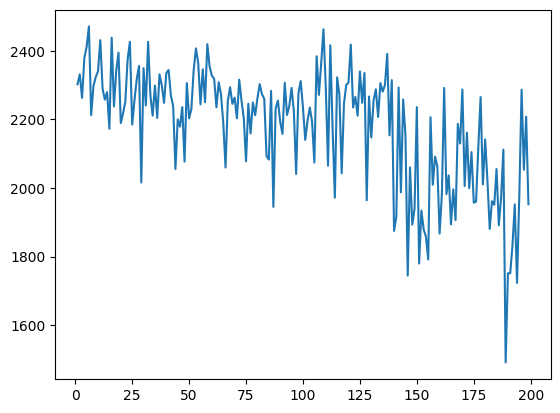

['Djokovic, Novak',
 'Sinner, Jannik',
 'Alcaraz, Carlos',
 'Medvedev, Daniil',
 'Zverev, Alexander',
 'Rublev, Andrey',
 'Ruud, Casper',
 'Tsitsipas, Stefanos',
 'Hurkacz, Hubert',
 'Dimitrov, Grigor',
 'Minaur, Alex De',
 'Rune, Holger V. N.',
 'Fritz, Taylor',
 'Shelton, Ben',
 'Humbert, Ugo',
 'Paul, Tommy',
 'Bublik, Alexander',
 'Khachanov, Karen',
 'Baez, Sebastian',
 'Auger Aliassime, Felix',
 'Mannarino, Adrian',
 'Cerundolo, Francisco',
 'Lehecka, Jiri',
 'Jarry, Nicolas',
 'Tiafoe, Francis',
 'Griekspoor, Tallon',
 'Korda, Sebastian',
 'Etcheverry, T. Martin',
 'Musetti, Lorenzo',
 'Norrie, Cameron',
 'Navone, Mariano',
 'Tabilo, Alejandro',
 'Davidovich Fokina, Alejandro',
 'Fils, Arthur',
 'Thompson, Jordan',
 'Marozsan, Fabian',
 'Arnaldi, Matteo',
 'Monfils, Gael',
 'Safiullin, Roman',
 'Draper, Jack',
 'Struff, Jan-Lennard',
 'Popyrin, Alexei',
 'Eubanks, Christopher',
 'Djere, Laslo',
 'Machac, Tomas',
 'Ofner, Sebastian',
 'Sonego, Lorenzo',
 'Diaz Acosta, Facundo',
 

In [81]:
ratingList = []
nameList = []
rankList = []
ATPRankingPoints = []
for i in range(1,200):
  rankList.append(i)
  val = allMatchdf[(allMatchdf.Player1_Rank==i) | (allMatchdf.Player2_Rank==i)].iloc[0]

  if val["Player1_Rank"] ==i :
      ratingList.append(val["Player1_Glicko2Rating"])
      nameList.append(val["Player1"])
      ATPRankingPoints.append(val["Player1_RankingPoints"])
  elif val["Player2_Rank"] ==i :
      ratingList.append(val["Player2_Glicko2Rating"])
      nameList.append(val["Player2"])
      ATPRankingPoints.append(val["Player2_RankingPoints"])

import matplotlib.pyplot as plt

plt.plot(rankList, ratingList)
plt.show()
nameList